In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('hanoi_quality.csv')
df1=df.reset_index()['pm25']

In [3]:
df1.shape

(1920,)

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
df1.shape

(1920, 1)

In [6]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [7]:
print(train_size)
print(test_size)

1344
576


In [8]:
print(train_data.shape)
print(test_data.shape)


(1344, 1)
(576, 1)


In [9]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [10]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)


(1243, 100)
(1243,)
(475, 100)
(475,)


In [12]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [13]:
print(X_train.shape)
print(X_test.shape)

(1243, 100, 1)
(475, 100, 1)


In [14]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 390ms/step - loss: 0.0443 - val_loss: 0.0294
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - loss: 0.0228 - val_loss: 0.0256
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 372ms/step - loss: 0.0185 - val_loss: 0.0252
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 418ms/step - loss: 0.0180 - val_loss: 0.0243
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 482ms/step - loss: 0.0191 - val_loss: 0.0242
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 429ms/step - loss: 0.0195 - val_loss: 0.0252
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 542ms/step - loss: 0.0200 - val_loss: 0.0245
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 423ms/step - loss: 0.0185 - val_loss: 0.0237
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 314ms/step - loss: 0.0198 - val_loss: 0.0273
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 301ms/step - loss: 0.0185 - val_loss: 0.0231
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - loss: 0.0203 - val_loss: 0.0228
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━

In [16]:
X_test.shape

(475, 100, 1)

In [17]:
# 10. Dự báo dữ liệu test,
train_predict=model.predict(X_train)
y_pred=model.predict(test_data.reshape(test_data.shape[0],test_data.shape[1] , 1))


39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 351ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step


In [18]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)


In [19]:
test_data.shape

(576, 1)

In [20]:
y_pred.shape

(576, 1)

In [21]:
ytest=scaler.inverse_transform(test_data)
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(ytest - y_pred)/np.abs(ytest))*100

print('Testing MAPE:', test_mape)

# Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 54.47993397786675
Testing MAPE: 58.88028810601941
Testing MAE: 49.300698871413864


In [22]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape

(1, 516)

In [23]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=516
i=0
while(i<90):

    if(len(temp_input)>516):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


(1, 516)
[0.42019928]
517
1 day input [0.79534884 0.70232558 0.44186047 0.62790698 0.90697674 0.89767442
 0.81860465 0.67906977 0.44651163 0.49302326 0.62325581 0.48837209
 0.22325581 0.46511628 0.49302326 0.73488372 0.81395349 0.90697674
 0.95348837 0.69302326 0.30697674 0.51162791 0.65581395 0.58139535
 0.48837209 0.68837209 0.86046512 0.71162791 0.62325581 0.48837209
 0.37674419 0.35348837 0.54883721 0.47906977 0.3255814  0.55348837
 0.25581395 0.25581395 0.23255814 0.30697674 0.4        0.32093023
 0.45581395 0.59534884 0.82325581 0.59069767 0.66511628 0.55348837
 0.68372093 0.45116279 0.45116279 0.20930233 0.31627907 0.5627907
 0.73023256 0.69302326 0.5627907  0.84186047 0.79069767 0.58604651
 0.76744186 0.65581395 0.44651163 0.4        0.67906977 0.60930233
 0.4744186  0.55813953 0.30232558 0.53953488 0.62325581 0.34418605
 0.29302326 0.28837209 0.26976744 0.29767442 0.39534884 0.60465116
 0.53488372 0.54883721 0.40930233 0.25116279 0.24186047 0.30232558
 0.31162791 0.35813953 0.

In [24]:
print(x_input.shape)


(1, 516, 1)


In [25]:
print(test_data.shape)

(576, 1)


In [26]:
test_data.shape

(576, 1)

In [27]:
y_pred.shape

(576, 1)

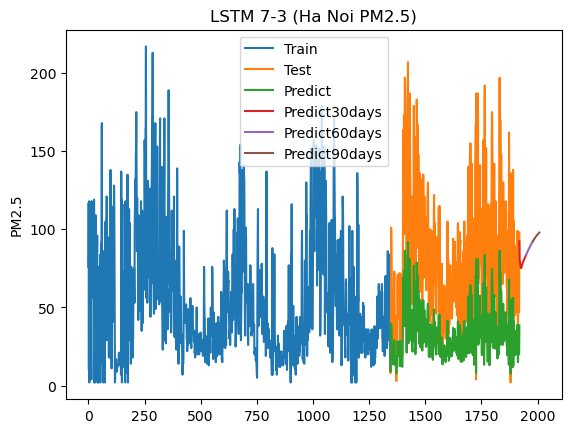

In [31]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Train','Test','Predict','Predict30days', 'Predict60days', 'Predict90days'])
plt.title('LSTM 7-3 (Ha Noi PM2.5)')
plt.ylabel('PM2.5')
plt.show()

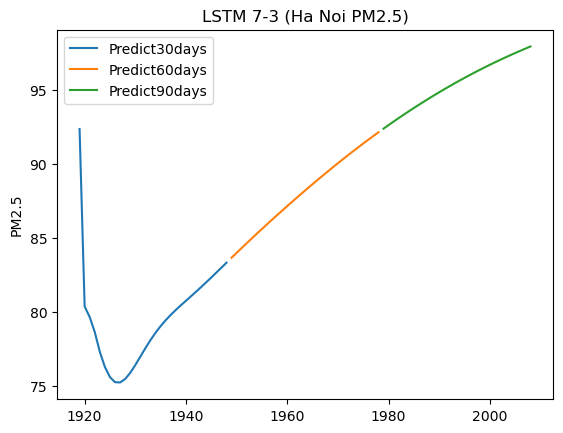

In [32]:
# 14.Vẽ hình
# Dự đoán 90 ngày tiếp theo

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.title('LSTM 7-3 (Ha Noi PM2.5)')
plt.ylabel('PM2.5')
plt.show()

In [30]:
print(scaler.inverse_transform(lst_output))

[[92.34284413]
 [80.37100193]
 [79.64927402]
 [78.63890108]
 [77.3045778 ]
 [76.28246632]
 [75.59808773]
 [75.2596308 ]
 [75.23838994]
 [75.47264171]
 [75.88844356]
 [76.41344842]
 [76.98583034]
 [77.55873767]
 [78.10138237]
 [78.59770086]
 [79.04317585]
 [79.44151726]
 [79.80134961]
 [80.13322604]
 [80.44768688]
 [80.75381157]
 [81.05853942]
 [81.36645821]
 [81.67998356]
 [81.99978825]
 [82.32528922]
 [82.65519214]
 [82.98777339]
 [83.32132858]
 [83.65440321]
 [83.98583111]
 [84.3147729 ]
 [84.64076084]
 [84.96362832]
 [85.28336895]
 [85.60009164]
 [85.91395658]
 [86.22516882]
 [86.53388214]
 [86.84017342]
 [87.14410675]
 [87.44566289]
 [87.7447201 ]
 [88.04123995]
 [88.33513913]
 [88.62628949]
 [88.9145757 ]
 [89.19989523]
 [89.48217762]
 [89.76130751]
 [90.03725928]
 [90.30994964]
 [90.57932732]
 [90.8453795 ]
 [91.10802931]
 [91.36723188]
 [91.62301284]
 [91.87526968]
 [92.12404725]
 [92.36928788]
 [92.61094671]
 [92.84899813]
 [93.08344212]
 [93.31424025]
 [93.54141173]
 [93.76488